In [1]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import json



In [2]:
def select_samples(df, number_per_sector=3, total_number=100):
    # Check if number per sector * unique sectors is greater than total number
    if number_per_sector * df['GICS Sector'].nunique() > total_number:
        raise ValueError("Sample per sector should be less or equal to total number")
    
    selected_companies = pd.DataFrame(columns=df.columns)
    selected_companies = selected_companies.drop_duplicates(subset='CIK', keep='first')

    
    # Iterate over each unique sector
    for sector in df['GICS Sector'].unique():
        # Get random samples from the current sector
        sector_samples = df[df['GICS Sector'] == sector].sample(n=number_per_sector)
        selected_companies = pd.concat([selected_companies, sector_samples])
        
    # Calculate remaining samples needed
    remaining_samples = total_number - (number_per_sector * df['GICS Sector'].nunique())
    
    # Remove previously selected companies from the pool
    remaining_pool = df.drop(selected_companies.index)
    
    # Get additional random samples from the remaining pool
    remaining_samples = min(remaining_samples, len(remaining_pool))
    remaining_samples_df = remaining_pool.sample(n=remaining_samples)
    
    # Concatenate both selected samples
    selected_companies = pd.concat([selected_companies, remaining_samples_df])
    
    return selected_companies


In [3]:
# Define the file path
file_path = "sp500_ten_year_dictionaries.json"

# Load the JSON file back into a list of dictionaries
with open(file_path, 'r') as json_file:
    document_dictionaries = json.load(json_file)

In [58]:
# Fetch the webpage
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Find the first table on the page
table = soup.find_all('table')[0]

# Read the table into a pandas DataFrame
sp500_index = pd.read_html(str(table))[0]

sp500_index.to_excel('sp500_constituents.xlsx', index=True)
sp500_index['CIK'] = sp500_index['CIK'].astype(str)
sp500_index['CIK'] = sp500_index['CIK'].str.zfill(10)


avaiable_CIKs = set([d['CIK'] for d in document_dictionaries])
avaiable_CIKs = sp500_index[sp500_index['CIK'].isin(avaiable_CIKs)]
# print(aviable_CIKs)

selected_samples = select_samples(avaiable_CIKs, number_per_sector=3, total_number=100)

# Get normalized value counts for each DataFrame
sp500_sector_norm_counts = sp500_index['GICS Sector'].value_counts(normalize=True).reset_index().round(3)
selected_samples_sector_norm_counts = selected_samples['GICS Sector'].value_counts(normalize=True).reset_index()

# Rename columns for clarity
sp500_sector_norm_counts.columns = ['GICS Sector', 'SP500 Proportion']
selected_samples_sector_norm_counts.columns = ['GICS Sector', 'Selected Proportion']

# Merge the two DataFrames on the 'GICS Sector'
sector_comparison = pd.merge(sp500_sector_norm_counts, selected_samples_sector_norm_counts, 
                             on='GICS Sector', how='outer')


selected_companies = list(selected_samples['Security'].unique())
selected_CIK = list(selected_samples['CIK'].unique())
selected_CIK = [str(cik).zfill(10) for cik in selected_CIK]

# Display the tables
display(sp500_index.head())
display(sector_comparison)
print(selected_companies)



selected_companies_dict = {}
# print(selected_CIK)
for d in document_dictionaries:
    CIK = d['CIK'].zfill(10)
#     print(CIK)
    if CIK in selected_CIK:
        if d['CIK'] not in selected_companies_dict:
            selected_companies_dict[d['CIK']] = [d]
        else:
            selected_companies_dict[d['CIK']].append(d)

            
len(selected_companies_dict)


,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,0000066740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,0000091142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,0000001800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,0001551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,0001467373,1989


,GICS Sector,SP500 Proportion,Selected Proportion
0,Industrials,0.155,0.16
1,Financials,0.143,0.10
2,Health Care,0.127,0.14
3,Information Technology,0.127,0.14
4,Consumer Discretionary,0.105,0.06
5,Consumer Staples,0.076,0.06
6,Real Estate,0.062,0.08
7,Utilities,0.060,0.08
8,Materials,0.056,0.09
9,Energy,0.046,0.03


['Copart', 'Republic Services', 'Howmet Aerospace', 'Boston Scientific', 'Danaher Corporation', 'LabCorp', 'Adobe Inc.', 'Gen Digital', 'Intel', 'American Water Works', 'Southern Company', 'Entergy', 'Citizens Financial Group', 'Comerica', 'Fidelity National Information Services', 'Amcor', 'Albemarle Corporation', 'FMC Corporation', 'Caesars Entertainment', 'Lululemon Athletica', 'Mohawk Industries', 'Public Storage', 'Digital Realty', 'Vici Properties', 'Take-Two Interactive', 'T-Mobile US', 'Verizon', 'Kellanova', 'Constellation Brands', 'Dollar Tree', 'ConocoPhillips', 'Occidental Petroleum', 'APA Corporation', 'Jack Henry & Associates', 'PPL Corporation', 'Dexcom', 'Booking Holdings', 'Walgreens Boots Alliance', 'Walt Disney', '3M', 'Cadence Design Systems', 'Iron Mountain', 'FedEx', 'Apple Inc.', 'Regency Centers', 'PTC', 'Amgen', 'Keysight', 'Fleetcor', 'Charles Schwab Corporation', 'Generac', 'Leidos', 'Avery Dennison', 'Nucor', 'Bio-Rad', 'Eaton Corporation', 'Huntington Ingall

100

In [5]:
avaiable_CIKs_set = set(avaiable_CIKs['CIK'])
avaiable_CIKs_set = ((avaiable_CIKs_set)-(set(selected_samples['CIK'])))
len(avaiable_CIKs_set)

319

year
2014    64
2015    81
2016    84
2017    84
2018    85
2019    81
2020    76
2021    88
2022    93
2023    92
2024     1
Name: count, dtype: int64


<Axes: xlabel='year'>

<Axes: xlabel='CIK'>

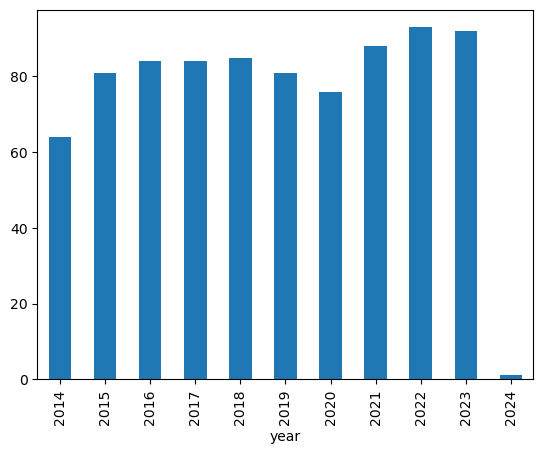

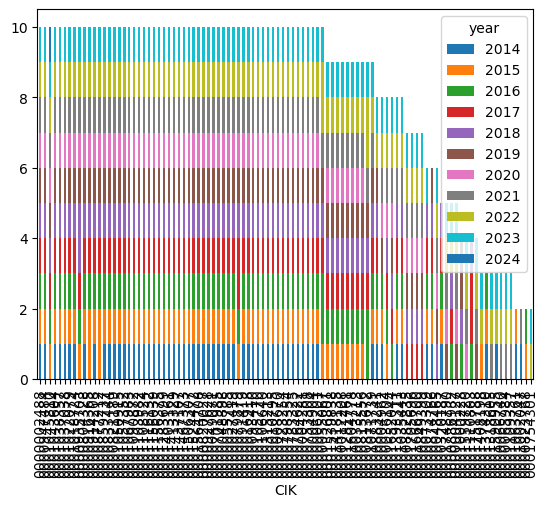

In [ ]:
# Flatten the dictionary into a list of dictionaries
flattened_list = []
for cik, documents in selected_companies_dict.items():
    for document in documents:
        document['CIK'] = cik  # Add CIK to each document
        flattened_list.append(document)

# Create DataFrame from the flattened list
df = pd.DataFrame(flattened_list)


In [7]:
selected_companies_df = pd.DataFrame([item for sublist in selected_companies_dict.values() for item in sublist])

def select_random_row(group):
    return group.sample(n=1)

# Group by 'CIK' and apply the function to select one random row per group
random_doc_df = selected_companies_df.groupby('CIK', group_keys=False).apply(select_random_row)

# Reset index if needed
random_doc_df.reset_index(drop=True, inplace=True)

# Initialize an empty list to store rows
rows = []

# Iterate through random_doc_df
for index, row in random_doc_df.iterrows():
    # Iterate through each document in document_df
    for doc in row['document_df']:
        # Create a new row with document data and additional columns
        new_row = {
            'company_name': row['company_name'],
            'year': row['year'],
            'form': row['form'],
            'CIK': row['CIK'],
            **doc  # Unpack document dictionary
        }
        # Append the new row to the list
        rows.append(new_row)

# Create the sample_df DataFrame from the list of rows
sample_df = pd.DataFrame(rows)

sample_df = pd.merge(sample_df, sp500_index[['CIK', 'GICS Sector']], on='CIK', how='left')

# Rename the 'GICS Sector' column to 'Sector'
sample_df.rename(columns={'GICS Sector': 'Sector'}, inplace=True)



sample_df = sample_df[['text', 'type', 'item', 'title_level',
                       'CIK','company_name', 'Sector', 'year', 'form', 
                       'token_count', 'word_count', 'char_count']]


sample_df['item'].value_counts()


item
Item 8          35851
Item 7          25007
Item 1A         14134
Item 1          13919
Item 15          7985
PreText          3897
Item 7A          3762
Item 16          3288
Item 1B          1715
Item 5           1520
Item 9A          1272
Item 2           1184
Item 6           1103
Item 14          1024
Item 11           605
Item 3            548
Item 10           523
Item 12           492
Item 4            447
Item 9B           333
Item 9            240
Item 13           224
Item 1 and 2      205
Item 9C           120
Name: count, dtype: int64

In [8]:
sample_df = sample_df[sample_df['type'].isin(['NarrativeText','title','list'])]
sample_df = sample_df[sample_df['item'].isin(['Item 1', 'Item 1A','Item 2', 'Item 3', 'Item 4', 'Item 7'
                                              'Item 7A', 'Item 10'])]

print("{:,}".format(len(sample_df)))
sample_df.sample(5)

29,453


,text,type,item,title_level,CIK,company_name,Sector,year,form,token_count,word_count,char_count
5594,“Treasury Loan Warrant Shares” means the share...,NarrativeText,Item 1,2.0,0000006201,American Airlines Group Inc.,Industrials,2022,10-K,41,35,219
103593,We use both internally developed systems and t...,NarrativeText,Item 1A,2.0,0001559720,"Airbnb, Inc.",Consumer Discretionary,2022,10-K,144,123,852
67697,- delivering economic production and proved re...,list,Item 1,-1.0,0001038357,PIONEER NATURAL RESOURCES CO,Energy,2020,10-K,17,14,129
104938,Competition for popular programming licensed f...,NarrativeText,Item 1A,2.0,0001564708,NEWS CORP,Communication Services,2023,10-K,364,303,2013
13413,These products are primarily sold through elec...,NarrativeText,Item 1,2.0,0000048898,HUBBELL INC,Industrials,2017,10-K,71,57,454


In [9]:
import json
import random
import pandas as pd
import transformers
from transformers import pipeline
import transformers 
from tqdm.notebook import tqdm 


In [10]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import scipy

tokenizer_sentiment = AutoTokenizer.from_pretrained("ProsusAI/finbert")
finbert_classifier = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

tokenizer_esg = AutoTokenizer.from_pretrained("yiyanghkust/finbert-esg")
finbert_esg_classifier = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-esg")

# finbert_classifier = pipeline("text-classification", model="ProsusAI/finbert")
# finbert_esg_classifier = pipeline("text-classification", model="yiyanghkust/finbert-esg")


/Users/emanueleferrari/anaconda3/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [11]:
%%time


s = (sample_df.sample(int(len(sample_df)/10000)))


sample_processed_df = []
for index, row in tqdm(sample_df.iterrows(),total=len(sample_df), desc="Calculating finbert sentiment and finbert-esg scores"):
    t = row['text']
    (t)
    inputs_sentiment = tokenizer_sentiment(t, return_tensors="pt")
    inputs_esg = tokenizer_esg(t, return_tensors="pt")
    
    with torch.no_grad():
        logits_sentiment = finbert_classifier(**inputs_sentiment).logits
        logits_esg = finbert_esg_classifier(**inputs_esg).logits
    scores_sentiment = {'sentiment_'+k: v for k, v in zip(finbert_classifier.config.id2label.values(), scipy.special.softmax(logits_sentiment.numpy().squeeze()))}
    scores_esg = {'esg_'+k: v for k, v in zip(finbert_esg_classifier.config.id2label.values(), scipy.special.softmax(logits_esg.numpy().squeeze()))}
    
    
    for key in scores_sentiment.keys():
        row[key] = scores_sentiment[key]

    for key in scores_esg.keys():
        row[key] = scores_esg[key]

    sample_processed_df.append(row)
    
sample_processed_df = pd.DataFrame(sample_processed_df)


Calculating finbert sentiment and finbert-esg scores:   0%|          | 0/29453 [00:00<?, ?it/s]

CPU times: user 1d 12h 27min 43s, sys: 4h 35min 41s, total: 1d 17h 3min 25s
Wall time: 5h 26min 29s


In [65]:
sample_processed_df = sample_processed_df[['text', 'esg_None', 'esg_Environmental', 'esg_Social', 'esg_Governance',
                                           'type', 'item', 'title_level', 'CIK', 'company_name', 'Sector',
                                           'year', 'form', 'token_count', 'word_count', 'char_count',
                                           'sentiment_positive', 'sentiment_negative', 'sentiment_neutral']]

sample_processed_df.reset_index(inplace=True, drop=True)


# Save as CSV
sample_processed_df.to_excel('sample_processed_UNLABELLED_Full.xlsx', index=True)



In [13]:
sample_processed_df[sample_processed_df['esg_Social'] > 0.9]
sample_processed_df[(sample_processed_df['esg_None'] < 0.6) & 
                              (sample_processed_df['esg_Environmental'] <= 0.6) & 
                              (sample_processed_df['esg_Social'] <= 0.6) & 
                              (sample_processed_df['esg_Governance'] <= 0.6)]


,text,esg_None,esg_Environmental,esg_Social,esg_Governance,type,item,title_level,CIK,company_name,Sector,year,form,token_count,word_count,char_count,sentiment_positive,sentiment_negative,sentiment_neutral
22,On the Investor Relations pages of our Website...,0.437137,0.007394,0.025659,0.529809,NarrativeText,Item 1,2.0,0000002488,ADVANCED MICRO DEVICES INC,Information Technology,2016,10-K,198,152,932,0.022170,0.024997,0.952833
36,An APU is a processing unit that integrates a ...,0.506897,0.478408,0.005425,0.009271,NarrativeText,Item 1,2.0,0000002488,ADVANCED MICRO DEVICES INC,Information Technology,2016,10-K,137,106,638,0.279015,0.014919,0.706066
129,"discharge of pollutants into the environment, ...",0.599015,0.366993,0.013747,0.020244,NarrativeText,Item 1,2.0,0000002488,ADVANCED MICRO DEVICES INC,Information Technology,2016,10-K,269,223,1464,0.029829,0.346694,0.623477
262,- remediating any data security breach and add...,0.371898,0.017106,0.218892,0.392104,list,Item 1A,-1.0,0000002488,ADVANCED MICRO DEVICES INC,Information Technology,2016,10-K,15,11,81,0.096108,0.078705,0.825188
291,- expropriation;,0.369847,0.090947,0.490501,0.048705,list,Item 1A,0.0,0000002488,ADVANCED MICRO DEVICES INC,Information Technology,2016,10-K,6,1,16,0.024711,0.206959,0.768330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28996,"Source: Nielsen, January 2022",0.545153,0.085074,0.339342,0.030431,NarrativeText,Item 1,2.0,0001754301,Fox Corp,Communication Services,2022,10-K,7,4,29,0.018943,0.047776,0.933282
29049,Credible,0.484118,0.102079,0.331739,0.082063,NarrativeText,Item 1,6.0,0001754301,Fox Corp,Communication Services,2022,10-K,1,1,8,0.101070,0.042106,0.856824
29050,Credible,0.484118,0.102079,0.331739,0.082063,NarrativeText,Item 1,6.0,0001754301,Fox Corp,Communication Services,2022,10-K,1,1,8,0.101070,0.042106,0.856824
29055,Flutter,0.093363,0.372045,0.516104,0.018487,NarrativeText,Item 1,6.0,0001754301,Fox Corp,Communication Services,2022,10-K,1,1,7,0.084159,0.042818,0.873023


In [27]:
def generate_labeled_data(df, total_number=2000, labelled_number=250, uncertain_labels=500, 
                          threshold_none=0.9, threshold_e=0.9, threshold_s=0.9, threshold_g=0.65, 
                          threshold_uncertain=0.6):
    # Filter rows based on conditions
    df.drop_duplicates(subset=['text'], keep='first', inplace=True)
    df = df.sample(frac=1,random_state=3362)
    df_esg_None = df[df['esg_None'] > threshold_none]
    df_esg_None = df_esg_None.sample(labelled_number)
    df_esg_Environmental = df[df['esg_Environmental'] > threshold_e]
    df_esg_Environmental = df_esg_Environmental.sample(labelled_number)
    df_esg_Social = df[df['esg_Social'] > threshold_s]
    df_esg_Social = df_esg_Social.sample(labelled_number)
    df_esg_Governance = df[df['esg_Governance'] > threshold_g]
    df_esg_Governance = df_esg_Governance.sample(labelled_number)

    
    # Rows with none of the above over threshold_uncertain
    df_other = df[
        (~df.index.isin(df_esg_None.index)) &
        (~df.index.isin(df_esg_Environmental.index)) &
        (~df.index.isin(df_esg_Social.index)) &
        (~df.index.isin(df_esg_Governance.index))
    ]

    df_other = df_other[df_other[['esg_None', 'esg_Environmental', 'esg_Social', 'esg_Governance']].max(axis=1) < threshold_uncertain]
    df_other = df_other.sample(uncertain_labels)

    # Randomly select remaining rows
    remaining_rows = df[
        (~df.index.isin(df_esg_None.index)) &
        (~df.index.isin(df_esg_Environmental.index)) &
        (~df.index.isin(df_esg_Social.index)) &
        (~df.index.isin(df_esg_Governance.index)) &
        (~df.index.isin(df_other.index))
    ]

    df_random = remaining_rows.sample(total_number-uncertain_labels-(labelled_number*4))

    # Concatenate all DataFrames
    final_df = pd.concat([df_esg_None, df_esg_Environmental, df_esg_Social, df_esg_Governance, df_other, df_random])

    return final_df

training_set = generate_labeled_data(sample_processed_df)
training_set

,text,esg_None,esg_Environmental,esg_Social,esg_Governance,type,item,title_level,CIK,company_name,Sector,year,form,token_count,word_count,char_count,sentiment_positive,sentiment_negative,sentiment_neutral
14509,FlexArray software unifies and simplifies IT o...,0.910834,0.060180,0.017308,0.011678,NarrativeText,Item 1,2.0,0001002047,"NetApp, Inc.",Information Technology,2014,10-K,87,64,460,0.548749,0.010392,0.440859
10583,We also have a supply agreement with GE Health...,0.969548,0.006412,0.020157,0.003883,NarrativeText,Item 1A,2.0,0000859737,HOLOGIC INC,Health Care,2016,10-K,47,39,236,0.335916,0.011268,0.652816
21671,"In addition, our certificate of incorporation ...",0.988407,0.002798,0.003100,0.005695,NarrativeText,Item 1A,2.0,0001283699,"T-Mobile US, Inc.",Communication Services,2015,10-K,55,43,282,0.025124,0.047782,0.927094
28436,"Some of the factors, many of which are beyond ...",0.994019,0.001655,0.001472,0.002854,NarrativeText,Item 1A,2.0,0001705696,VICI PROPERTIES INC.,Real Estate,2021,10-K,40,37,210,0.023113,0.367120,0.609767
11405,"We are currently, and may in the future, becom...",0.982337,0.002831,0.007559,0.007273,NarrativeText,Item 1A,2.0,0000882835,ROPER TECHNOLOGIES INC,Information Technology,2021,10-K,113,99,669,0.018008,0.621663,0.360328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19138,Our operating results may suffer if our manufa...,0.995849,0.001254,0.001011,0.001886,title,Item 1A,7.0,0001090872,"AGILENT TECHNOLOGIES, INC.",Health Care,2019,10-K,18,17,106,0.019657,0.960718,0.019625
6258,NIKE’s athletic footwear products are designed...,0.979070,0.002734,0.014475,0.003721,NarrativeText,Item 1,2.0,0000320187,"NIKE, Inc.",Consumer Discretionary,2018,10-K,80,68,446,0.745941,0.008472,0.245588
5317,The steel products segment has experienced rec...,0.988205,0.004534,0.005170,0.002092,NarrativeText,Item 1,2.0,0000073309,NUCOR CORP,Materials,2017,10-K,175,144,906,0.612575,0.008489,0.378936
6054,If we are not successful in protecting our int...,0.990683,0.002503,0.001983,0.004831,title,Item 1A,8.0,0000105770,WEST PHARMACEUTICAL SERVICES INC,Health Care,2018,10-K,20,18,112,0.018711,0.832508,0.148782


In [63]:
# Save as CSV
training_set.to_csv('training_set_UNLABELLED.csv', index=False)

# Save as Excel
training_set.to_excel('training_set_UNLABELLED.xlsx', index=False)


In [29]:
# Filtering similar to sample_processed_df[sample_processed_df['esg_Social'] > 0.9]
print(f"{'esg_None':<{30}}",len(training_set[training_set['esg_None'] > 0.9])/len(training_set), '\t',len(training_set[training_set['esg_None'] > 0.9]))
print(f"{'esg_Social':<{30}}",len(training_set[training_set['esg_Social'] > 0.9])/len(training_set), '\t',len(training_set[training_set['esg_Social'] > 0.9]))
print(f"{'esg_Environmental':<{30}}",len(training_set[training_set['esg_Environmental'] > 0.9])/len(training_set), '\t',len(training_set[training_set['esg_Environmental'] > 0.9]))
print(f"{'esg_Governance':<{30}}",len(training_set[training_set['esg_Governance'] > 0.65])/len(training_set), '\t',len(training_set[training_set['esg_Governance'] > 0.65]))

below_60_all = training_set[(training_set['esg_None'] <= 0.6) & 
                              (training_set['esg_Environmental'] <= 0.6) & 
                              (training_set['esg_Social'] <= 0.6) & 
                              (training_set['esg_Governance'] <= 0.6)]

print(f"{'uncertain':<{30}}",len(below_60_all)/len(training_set),'\t',len(below_60_all))



esg_None                       0.319 	 638
esg_Social                     0.1375 	 275
esg_Environmental              0.129 	 258
esg_Governance                 0.125 	 250
uncertain                      0.2615 	 523


In [18]:
pretraining_CIKs = random.sample(list(avaiable_CIKs_set), len(avaiable_CIKs_set) - 100)
len(pretraining_CIKs)

219

In [19]:
pretrain_companies_dict = {}
# print(selected_CIK)
for d in document_dictionaries:
    CIK = d['CIK'].zfill(10)
#     print(CIK)
    if CIK in pretraining_CIKs:
        if d['CIK'] not in pretrain_companies_dict:
            pretrain_companies_dict[d['CIK']] = [d]
        else:
            pretrain_companies_dict[d['CIK']].append(d)

            
pretrain_companies_df = pd.DataFrame([item for sublist in pretrain_companies_dict.values() for item in sublist])
print(len(pretrain_companies_df))

# Initialize an empty list to store rows
rows = []

# Iterate through random_doc_df
for index, row in pretrain_companies_df.iterrows():
    # Iterate through each document in document_df
    for doc in row['document_df']:
        # Create a new row with document data and additional columns
        new_row = {
            'company_name': row['company_name'],
            'year': row['year'],
            'form': row['form'],
            'CIK': row['CIK'],
            **doc  # Unpack document dictionary
        }
        # Append the new row to the list
        rows.append(new_row)

# Create the sample_df DataFrame from the list of rows
pretrain_df = pd.DataFrame(rows)

pretrain_df = pd.merge(pretrain_df, sp500_index[['CIK', 'GICS Sector']], on='CIK', how='left')

# Rename the 'GICS Sector' column to 'Sector'
pretrain_df.rename(columns={'GICS Sector': 'Sector'}, inplace=True)



pretrain_df = pretrain_df[['text', 'type', 'item', 'title_level',
                       'CIK','company_name', 'Sector', 'year', 'form', 
                       'token_count', 'word_count', 'char_count']]


pretrain_df


1798


,text,type,item,title_level,CIK,company_name,Sector,year,form,token_count,word_count,char_count
0,Content before First Item.,ItemMarker,PreText,11.0,0000796343,ADOBE INC.,Information Technology,2023,10-K,5,4,28
1,FORM 10-K,title,PreText,9.0,0000796343,ADOBE INC.,Information Technology,2023,10-K,4,3,9
2,[TABLE_REPLACED_4],table,PreText,2.0,0000796343,ADOBE INC.,Information Technology,2023,10-K,7,3,18
3,Forward-Looking Statements,title,PreText,8.0,0000796343,ADOBE INC.,Information Technology,2023,10-K,4,3,26
4,"In addition to historical information, this An...",NarrativeText,PreText,6.0,0000796343,ADOBE INC.,Information Technology,2023,10-K,426,310,2077
...,...,...,...,...,...,...,...,...,...,...,...,...
2065166,Under the requirements of the Securities Excha...,NarrativeText,Item 15,2.0,0001555280,Zoetis Inc.,Health Care,2014,10-K,36,32,187
2065167,[TABLE_REPLACED_87],table,Item 15,2.0,0001555280,Zoetis Inc.,Health Care,2014,10-K,7,3,19
2065168,The exhibits listed below and designated with ...,NarrativeText,Item 15,2.0,0001555280,Zoetis Inc.,Health Care,2014,10-K,37,34,216
2065169,[TABLE_REPLACED_88],table,Item 15,2.0,0001555280,Zoetis Inc.,Health Care,2014,10-K,7,3,19


In [34]:
pretrain_df.groupby(['company_name', 'year']).ngroups


1776

In [20]:
pretrain_df = pretrain_df[pretrain_df['type'].isin(['NarrativeText','title','list'])]
pretrain_df = pretrain_df[pretrain_df['item'].isin(['Item 1', 'Item 1A','Item 2', 'Item 3', 'Item 4', 'Item 7'
                                              'Item 7A', 'Item 10'])]

print("{:,}".format(len(pretrain_df)))
pretrain_df.sample(5)

508,073


,text,type,item,title_level,CIK,company_name,Sector,year,form,token_count,word_count,char_count
863209,"- Waived deductibles, co-pays, and co-insuranc...",list,Item 1,-1.0,0001659166,Fortive Corp,Industrials,2020,10-K,33,21,127
613631,The credit facilities also contain other event...,NarrativeText,Item 1A,2.0,0000027904,"DELTA AIR LINES, INC.",Industrials,2016,10-K,105,88,569
1972565,Our results may be adversely affected if long-...,title,Item 1A,8.0,0001744489,Walt Disney Co,Communication Services,2019,10-K,23,20,133
942460,- statutory and regulatory changes;,list,Item 1A,0.0,0000765880,"HEALTHPEAK PROPERTIES, INC.",Real Estate,2019,10-K,6,4,35
1405712,Provisions of our certificate of incorporation...,title,Item 1A,7.0,0001120193,"NASDAQ, INC.",Financials,2014,10-K,42,34,227


In [60]:
pretrain_df.to_excel('pretrain_df_UNLABELLED.xlsx', index=False)
